<a href="https://colab.research.google.com/github/Kulikov17/MLDS_CV/blob/main/hw2_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW2**. Сто бед - одна UNet.

Так как по сегментации у нас нет занятия в курсе, а есть только лекции в онлайн-курсе, в этой домашке будут и некоторые вводные по теме, чтобы вы не чувствовали себя брошенными.

Максимум, который можно получить за это дз - **10 баллов**.

## **0. Введение**

Сегментация разная бывает, инстанс мы немножко видели в лекции по детекции, а семантик будет сейчас.

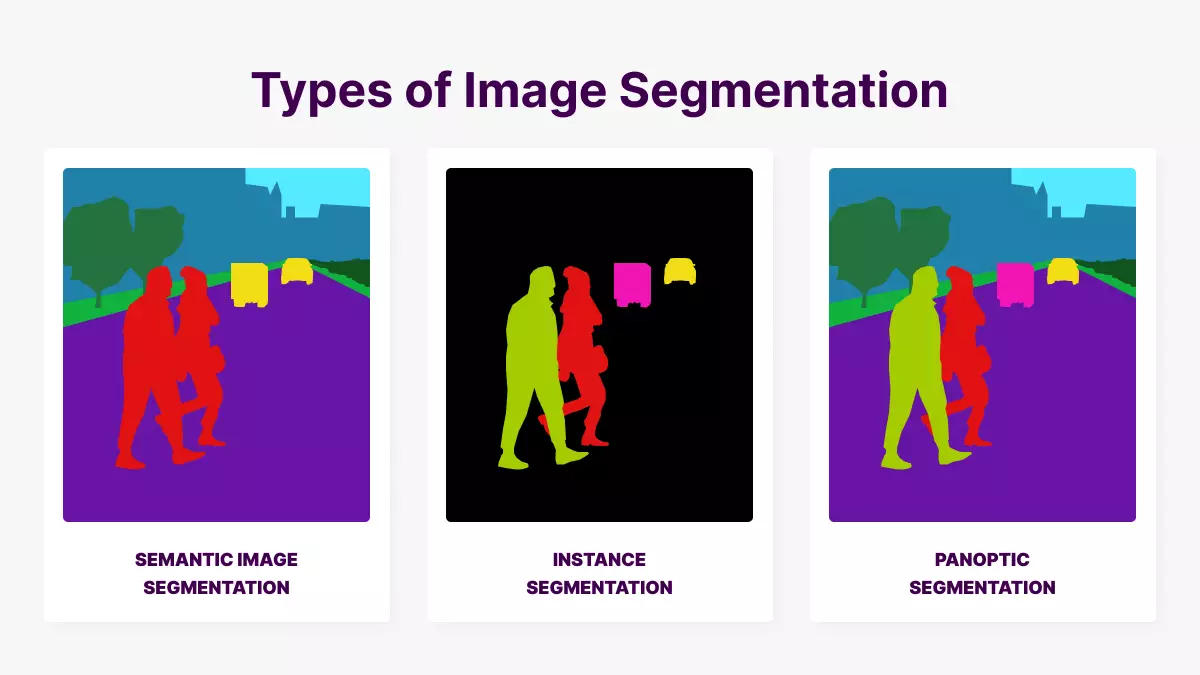

Фактически сегментация - это попиксельная классификация.

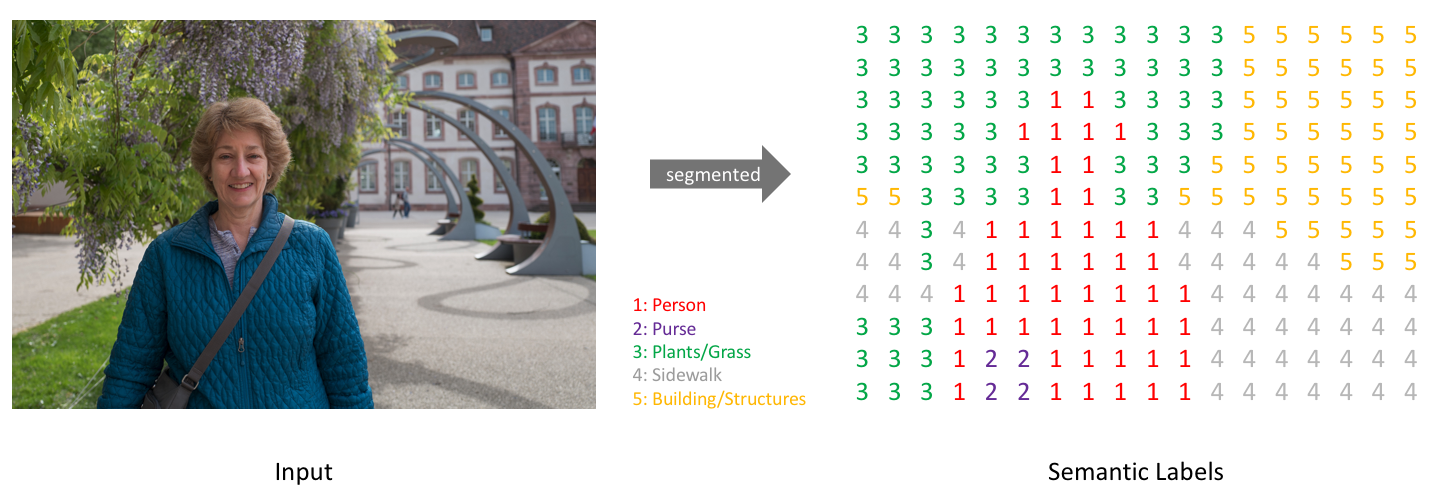

Видео с сегментированными машинками [смотреть тут](https://www.youtube.com/watch?v=ATlcEDSPWXY).

## **1. Подготовь данные**


Будем использовать данные с первого этапа **PicsArt AI Hackathon**. Скачать [тут](https://drive.google.com/file/d/18WuwEMabQVmYB_szumG7PobjuhtpkAVu/view?usp=sharing).
- Загрузим и распакуем данные
- Напишем класс `Dataset` для наших данных
- Посмотрим примеры данных

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt


import torchvision
import torch.utils.data as data
import torchvision.models as models
from torchvision.transforms import v2
from torchvision.io import read_image

import PIL
from PIL import Image
from glob import glob
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

In [ ]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


### **Задание 1** (2 балла)
Для того, чтобы учить сеть, нужен будет `Dataloader`, а значит и собственный `Dataset`. Чтобы собрать `Dataset`, надо понять как выглядят данные и аннотация, а также какие данные понадобятся вашей сетке для обучения.

Данные уже разделены на `train` и `test`, никакого кровосмешения больше не делаем.

**(1 балл)** Разархивируйте данные, загрузите их и визуализируйте фото и соответствующие им маски (4-5 шт). Посмотрите, как устроены маски. Подумайте, как будут соотноситься transform-ы для картинок и масок.

**(1 балл)** Напишите `FaceDataset`, заведите `transform`(ы), заведите по нему loader-ы для трейна и теста, проверьте что всё ок.

PS: лоадеры в конце ноутбука завел

In [ ]:
# ляля тут надо ваш путь к данным указать
!unzip -q  '/content/gdrive/MyDrive/MLDS_CV/HW2/data.zip' -d './'

In [ ]:
train_dir = './data/train'
test_dir = './data/test'

In [ ]:
train_images = sorted(list(map(lambda x: x.split('.')[0], os.listdir(train_dir))),key=lambda x: int(x))

In [ ]:
test_images = sorted(list(map(lambda x: x.split('.')[0], os.listdir(test_dir))),key=lambda x: int(x))

In [ ]:
def get_concat_img_mask(img_dir, img_name):
    mask_dir = img_dir + '_mask'

    img_file = os.path.join(img_dir, img_name + '.jpg')
    mask_file = os.path.join(mask_dir, img_name + '.png')

    img = Image.open(img_file)
    mask = Image.open(mask_file)

    dst = Image.new('RGB', (img.width + mask.width, max(img.height, mask.height)))
    dst.paste(img, (0, 0))
    dst.paste(mask, (img.width, 0))

    return dst

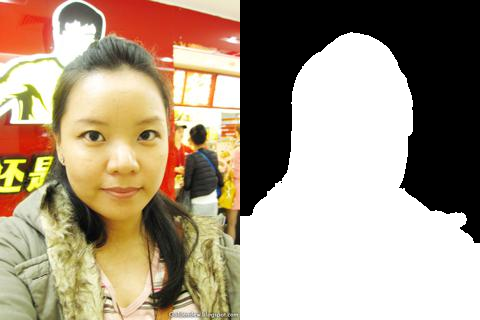

In [ ]:
get_concat_img_mask(train_dir, train_images[0])

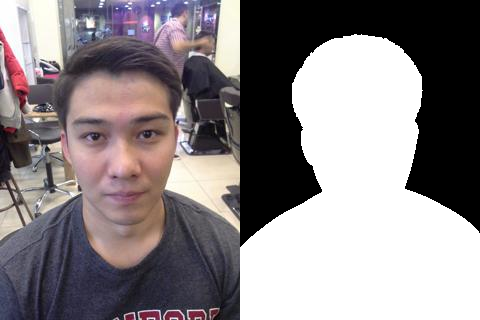

In [ ]:
get_concat_img_mask(train_dir, train_images[1])

Посмотрим в test

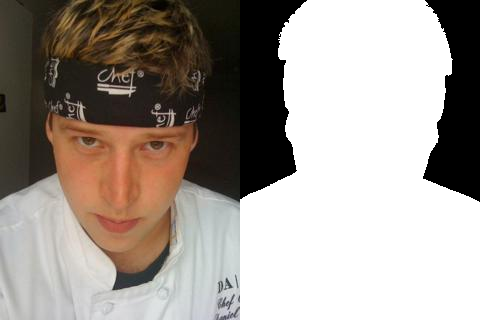

In [ ]:
get_concat_img_mask(test_dir, test_images[0])

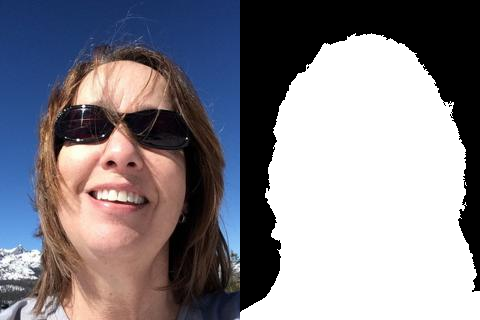

In [ ]:
get_concat_img_mask(test_dir, test_images[1])

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_paths = img_dir
        self.mask_paths = img_dir + '_mask'

        self.img_names = sorted(list(map(lambda x: x.split('.')[0], os.listdir(img_dir))), key=lambda x: int(x))

        self.transform = transform

    def __getitem__(self, idx):
        img_file = os.path.join(self.img_paths, self.img_names[idx] + '.jpg')
        mask_file = os.path.join(self.mask_paths, self.img_names[idx] + '.png')

        img = read_image(img_file) / 255.0
        mask = read_image(mask_file) / 255.0

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask


    def __len__(self):
        return len(self.img_names)

In [ ]:
transform = v2.Compose([v2.Resize(size=(240, 240))])

In [ ]:
train_dataset = FaceDataset(train_dir, transform=transform)
test_dataset = FaceDataset(test_dir, transform=transform)

In [ ]:
image, mask = train_dataset[0]

In [ ]:
# чекаем что размеры консистентны
image.shape, mask.shape

(torch.Size([3, 240, 240]), torch.Size([1, 240, 240]))

## **2. Разберись в U-net**

Как делать можно, но мы так не будем:

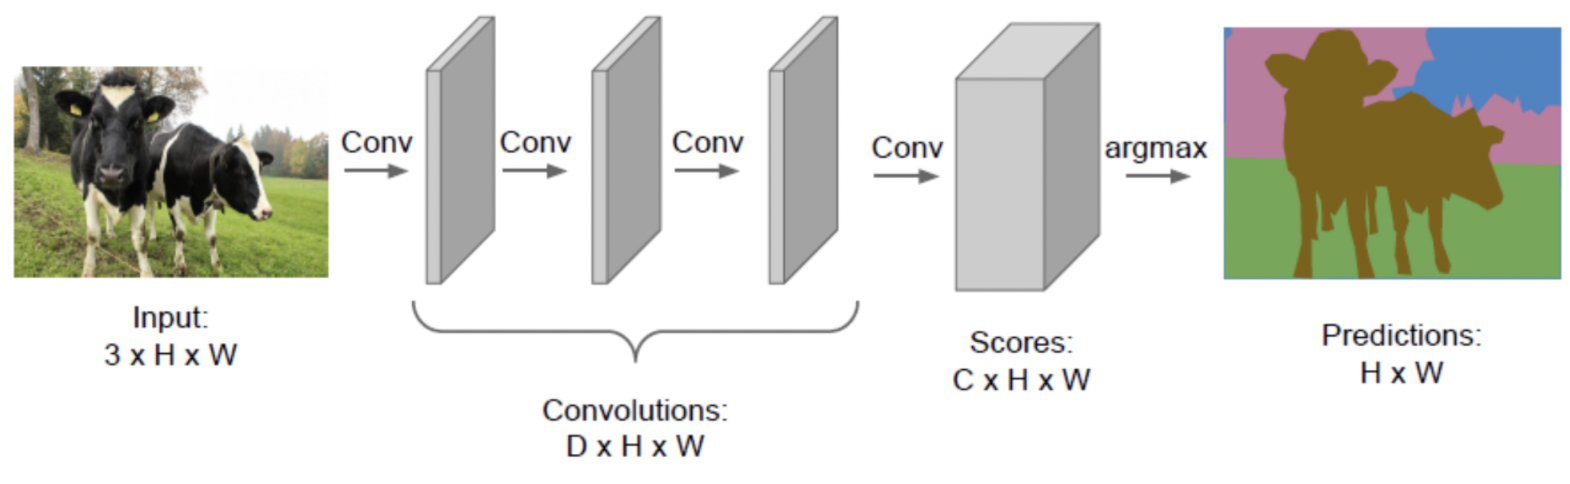

Или так ещё:

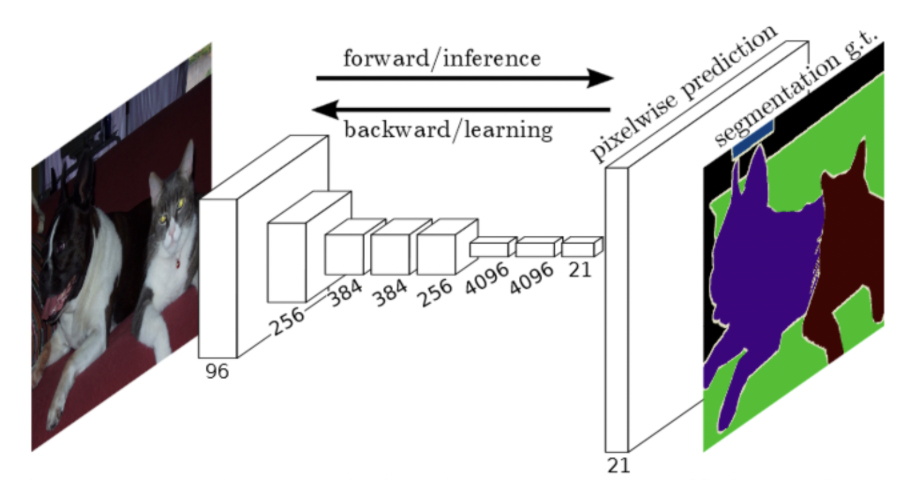

А будем так:

![](https://drive.google.com/uc?export=view&id=1r9oUaZInyoPO9d0pKDt6uOqBgzjZlSy3)

**UNet** - это
- очень сильный бейзлайн для большого спектра задач
- простая идея и реализация

### **Задание 2.** (2 балла)

Пишем энкодер!

Он у нас будет состоять из однообразных блоков, в которых будем только параметризовать количество входных и выходных каналов.

**(1 балл)** Напиши один **блок кодировщика** - он должен состоять из двух последовательных сверток, активаций и опционального батчнорма:

In [ ]:
# заведем отдельно себе функцию для светку дальнейшую
def conv3x3(in_channels, out_channels, dilation=1):
    return nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=False):
        super().__init__()

        self.batch_norm = batch_norm

        self.conv1 = conv3x3(in_channels, out_channels)

        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)

        if self.batch_norm:
            x = self.bn1(x)

        x = self.relu1(x)

        x = self.conv2(x)

        if self.batch_norm:
            x = self.bn2(x)

        x = self.relu2(x)

        return x

In [ ]:
block = EncoderBlock(3, 16)
block

EncoderBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
)

In [ ]:
x = torch.zeros(4, 3, 128, 128)

with torch.no_grad():
    print(block(x).shape)

torch.Size([4, 16, 128, 128])


**(1 балл)** А теперь напишем класс для всего энкодера.

Его конструкция определяется числом входных каналов, количеством фильтров в первом блоке и количеством блоков.

Помним также, что для работы сети нам нужно запоминать промежуточные активации. (Их будем по skip connection-ам ещё кидать).

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_filters, num_blocks, batch_norm=False):
        super().__init__()

        self.num_blocks = num_blocks

        # пройдем по блокам и посчитаем какие в каждом будут in и out channels
        # советую посмотреть на схему архитектуры
        # вход-выход последовательных должны очевидно совпадать
        # а количество выходных должно по степени двойки возрастать
        for i in range(num_blocks):
            in_channels = in_channels if not i else num_filters * (2**(i - 1))
            out_channels = num_filters * 2**i

            self.add_module(f'block{i + 1}', EncoderBlock(in_channels, out_channels, batch_norm))
            if i != num_blocks - 1:
                self.add_module(f'pool{i + 1}', nn.MaxPool2d(2, 2))

    def forward(self, x):
        acts = [] # нам некоторые выходы ещё понадобятся, будем их собирать

        for i in range(self.num_blocks):
            x = self.__getattr__(f"block{i+1}")(x) # вызываем блок, берем его результат
            acts.append(x) # кладем результирующую feature map

            if i != self.num_blocks - 1: # если это не последний блок, то дропаем пространственную размерность
              x = self.__getattr__(f"pool{i+1}")(x)
        return acts

In [ ]:
# проверяем что всё ок
encoder = Encoder(in_channels=3, num_filters=16, num_blocks=4)
encoder

Encoder(
  (block1): EncoderBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block2): EncoderBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (block3): EncoderBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu2): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
# проверяем что всё ок
x = torch.zeros(4, 3, 512, 512)

[_.shape for _ in encoder(x)]

[torch.Size([4, 16, 512, 512]),
 torch.Size([4, 32, 256, 256]),
 torch.Size([4, 64, 128, 128]),
 torch.Size([4, 128, 64, 64])]

### **Задание 3.** (2 балла)

Пишем декодер!

Блок декодера состоит из `transposed convolutions` c учетом `skip connections`: апскейлинга входа "снизу" + свертки, конкатенации `feature map` с одного уровня энкодера и декодера и их совместное сворачивание.

Есть несколько способов повысить разрешение тензора - например это разные типы интерполяции: `nearest neighbour`, `bilinear`, `bicubic`.

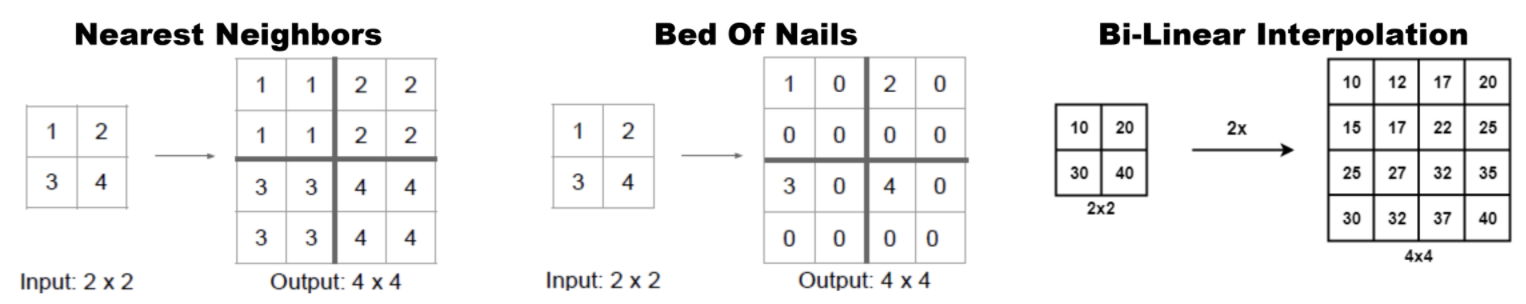

![](https://drive.google.com/uc?export=view&id=1Sazg6ZRQmw8xrJg4-MMccO0S_ib3kjvn)

В `pytorch` это можно делать с помощью модуля: [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) + `nn.conv2d`, а можно использовать сразу [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

В типичном репозитории `UNet` например есть [опция](https://github.com/milesial/Pytorch-UNet/blob/8f317cb13c17ef25a86b25a0c24390e04cd4db82/unet/unet_parts.py#L50) что делать.


**(1 балл)** Напиши блок декодера.

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        half_out_channels = out_channels // 2

        self.uppool = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upconv = conv3x3(out_channels, half_out_channels)
        self.conv1 = conv3x3(out_channels, half_out_channels)
        self.conv2 = conv3x3(half_out_channels, half_out_channels)

    def forward(self, down, left):
        x = self.uppool(down)
        x = self.upconv(x)
        x = torch.cat([left, x], 1)
        x = self.conv1(x)
        x = self.conv2(x)

        return x

**(1 балл)** Собери весь декодер из блочков.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        self.num_blocks = num_blocks

        # собираем блоки в обратном порядке
        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * (2**(num_blocks - i))))

    def forward(self, acts):
        # сперва берем последнюю в списке фичемапу как есть
        up = acts[-1]

        # далее начинаем их конкатенировать и прогонять через блоки
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{self.num_blocks - i}')(up, left)

        return up

In [ ]:
[_.shape for _ in encoder(x)]

[torch.Size([4, 16, 512, 512]),
 torch.Size([4, 32, 256, 256]),
 torch.Size([4, 64, 128, 128]),
 torch.Size([4, 128, 64, 64])]

In [ ]:
# проверяем что всё ок
decoder = Decoder(16, 3)
decoder

Decoder(
  (block3): DecoderBlock(
    (uppool): Upsample(scale_factor=2.0, mode='bilinear')
    (upconv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block2): DecoderBlock(
    (uppool): Upsample(scale_factor=2.0, mode='bilinear')
    (upconv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block1): DecoderBlock(
    (uppool): Upsample(scale_factor=2.0, mode='bilinear')
    (upconv): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [ ]:
# проверяем что всё ок
decoder(encoder(x)).shape

torch.Size([4, 16, 512, 512])

`U-Net` состоит из такого кодировщика и декодировщика, а также финального слоя классификации:

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, num_filters=16, num_blocks=4, batch_norm=False):
        super().__init__()

        self.encoder = Encoder(in_channels, num_filters, num_blocks, batch_norm)
        self.decoder = Decoder(num_filters, num_blocks - 1)
        self.final = nn.Conv2d(num_filters, num_classes, 1)

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [ ]:
model = UNet(num_classes=1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet(
  (encoder): Encoder(
    (block1): EncoderBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block2): EncoderBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block3): EncoderBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(inplace=True)
    )
    (

In [ ]:
# проверяем что всё ок
images = torch.randn(4, 3, 416, 416).to(device)

model(images).shape

torch.Size([4, 1, 416, 416])

## **3. Обучи сеть**



Ну а теперь будем учить.

### Вспомогательные функции

In [ ]:
# функция для обучения, используй на свое усмотрение
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()

    for batch_train, batch_answers in tqdm(train_loader):
        batch_train = batch_train.to(device)
        batch_answers = batch_answers.to(device)

        optimizer.zero_grad()

        model_answers = model(batch_train)

        new_loss = criterion(model_answers, batch_answers)
        new_loss.backward()
        optimizer.step()

Какую метрику использовать для оценки качества сегментации?
Можно IoU, а можно Dice.

В целом он очень близок к IoU, но в знаменателе полная сумма, а не объединение (поэтому числитель и удвоен, тк в знаменателе он тоже дважды учитывается).

А крут он тем, что из него можно сделать дифференцируемую функцию и свести задачу сразу к оптимизации целевой метрики.

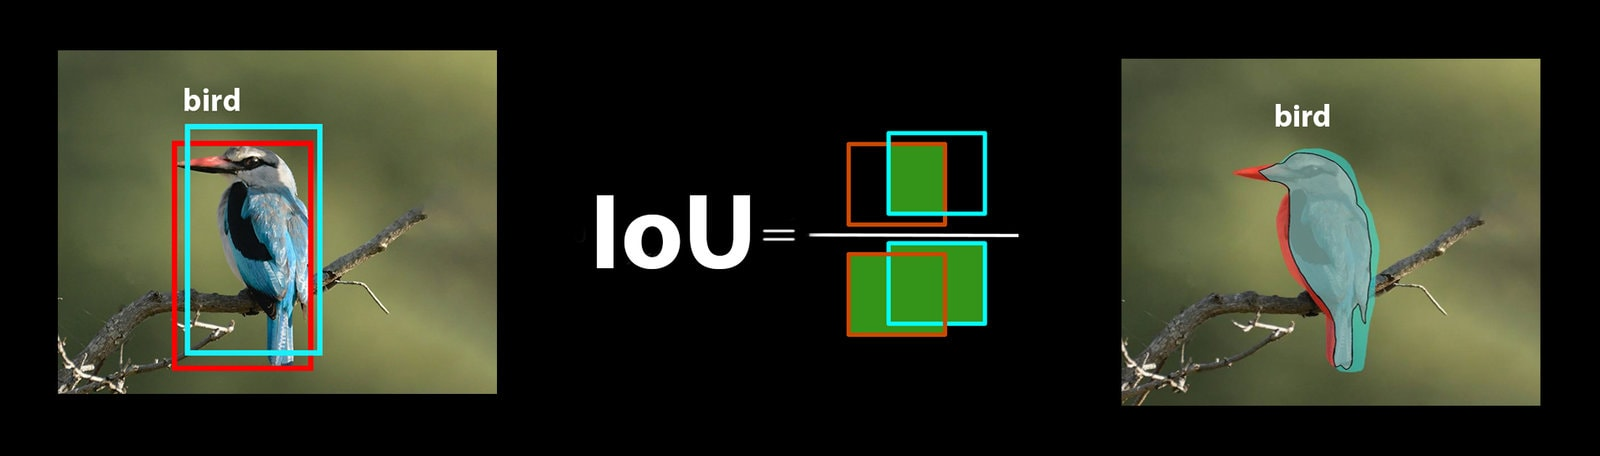

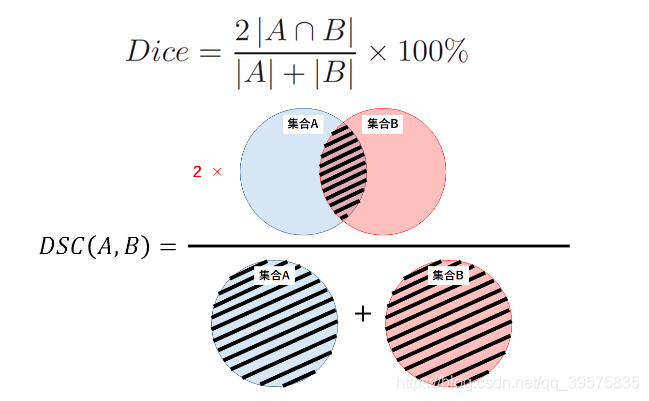

In [ ]:
def dice_score(pred_mask, true_mask):
    smooth = 1e-10
    true_mask = true_mask.astype(bool)
    pred_mask = pred_mask.astype(bool)

    intersection = (true_mask & pred_mask).sum()
    im_sum = true_mask.sum() + pred_mask.sum()

    return 2. * intersection / (im_sum + smooth)

In [ ]:
# функция для тестирования, меняй по своему усмотрению
def evaluate_loss(loader, model, criterion, th, device):
    model.eval()

    total_loss = 0
    total_dice = 0
    total_n = 0

    with torch.no_grad():
        for batch_test, batch_answers in tqdm(loader):
            batch_test = batch_test.to(device)
            batch_answers = batch_answers.to(device)

            model_answers = torch.sigmoid(model(batch_test))
            one_batch_loss = float(criterion(model_answers, batch_answers))

            # отсекаем неуверенные точки маски, по уверенным считаем dice
            model_mask = model_answers > th
            one_batch_dice = float(dice_score(model_mask.cpu().numpy(), batch_answers.cpu().numpy()))

            total_loss += one_batch_loss
            total_dice += one_batch_dice
            total_n += 1

    return (total_loss / total_n, total_dice / total_n)

### **Задание 4**. (2 балла)

А теперь эксперимент.

**(1 балл)** Собери все части вместе, обучи сетку, отрисуй свои результаты

**(1 балл)** Получи avg test dice score = 0.9.

In [53]:
# создаем лоадеры для данных
batch_size = 8

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          pin_memory=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         pin_memory=True)

In [54]:
# готовим всё важное: модель, оптимайзер, лосс
model = UNet(num_classes=1, batch_norm=True)
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
device

device(type='cuda')

In [57]:
model = model.to(device)

In [58]:
th = 0.5
epochs = 10

In [59]:
# main loop!

for epoch in range(1, epochs):
    train_epoch(model, optimizer, train_loader, criterion, device)
    train_loss, train_dice = evaluate_loss(train_loader, model, criterion, th, device)
    test_loss, test_dice = evaluate_loss(test_loader, model, criterion, th, device)

    print(f'Epoch {epoch}: avg train loss {train_loss:.04f}, avg train dice score {train_dice:.04f}')
    print(f'Avg test loss {test_loss:.04f}, avg test dice score {test_dice:.04f}')
    print('________________')

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1: avg train loss 0.5969, avg train dice score 0.8453
Avg test loss 0.6018, avg test dice score 0.8426
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2: avg train loss 0.5622, avg train dice score 0.8796
Avg test loss 0.5694, avg test dice score 0.8731
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3: avg train loss 0.5557, avg train dice score 0.8920
Avg test loss 0.5653, avg test dice score 0.8821
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4: avg train loss 0.5470, avg train dice score 0.9029
Avg test loss 0.5556, avg test dice score 0.8955
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5: avg train loss 0.5418, avg train dice score 0.9072
Avg test loss 0.5485, avg test dice score 0.9007
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6: avg train loss 0.5325, avg train dice score 0.9111
Avg test loss 0.5385, avg test dice score 0.9048
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7: avg train loss 0.5310, avg train dice score 0.9139
Avg test loss 0.5383, avg test dice score 0.9056
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8: avg train loss 0.5260, avg train dice score 0.9232
Avg test loss 0.5338, avg test dice score 0.9156
________________


  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9: avg train loss 0.5219, avg train dice score 0.9298
Avg test loss 0.5306, avg test dice score 0.9209
________________


Я достиг 0.9209 на последней эпохе

Посмотрим картинки из первого батча

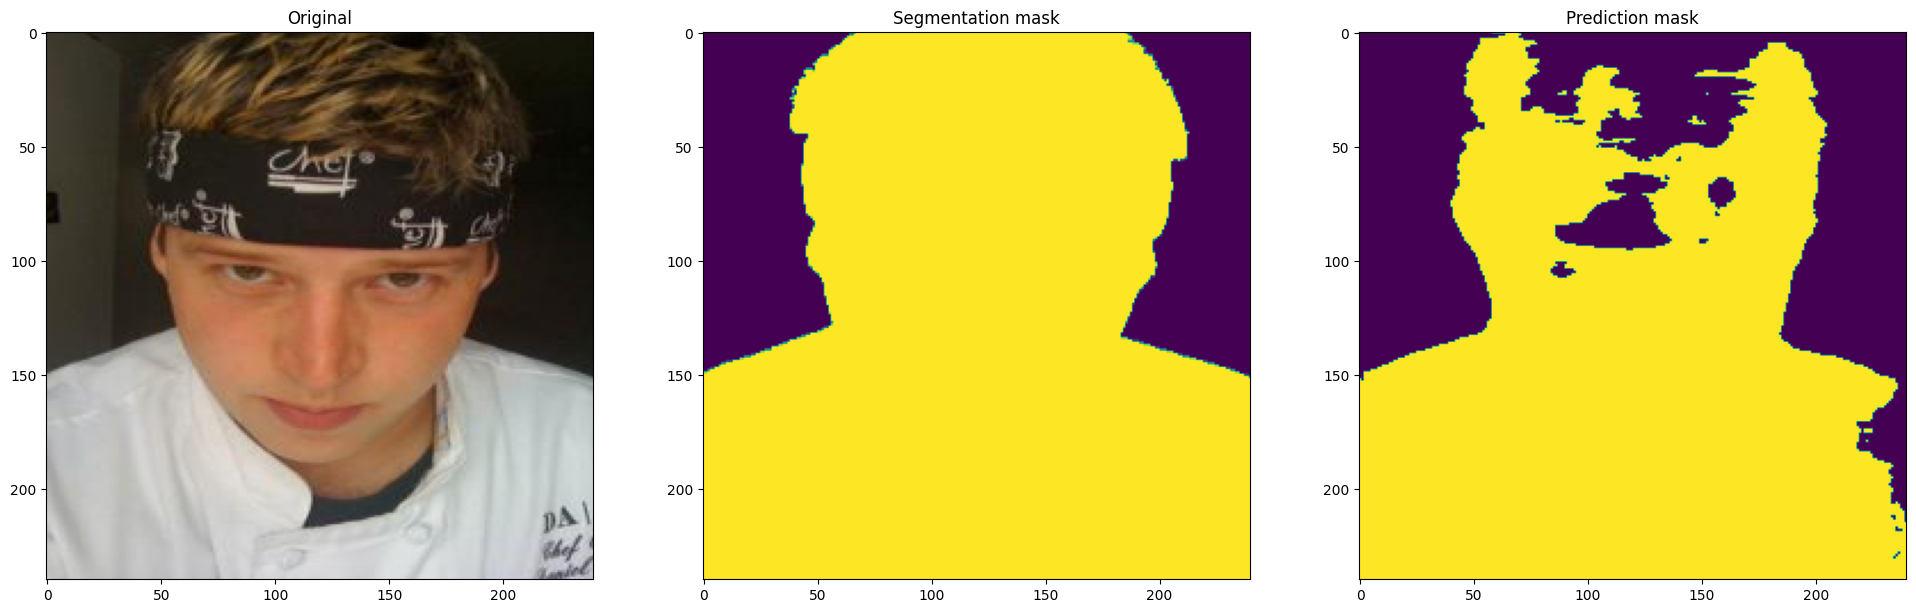

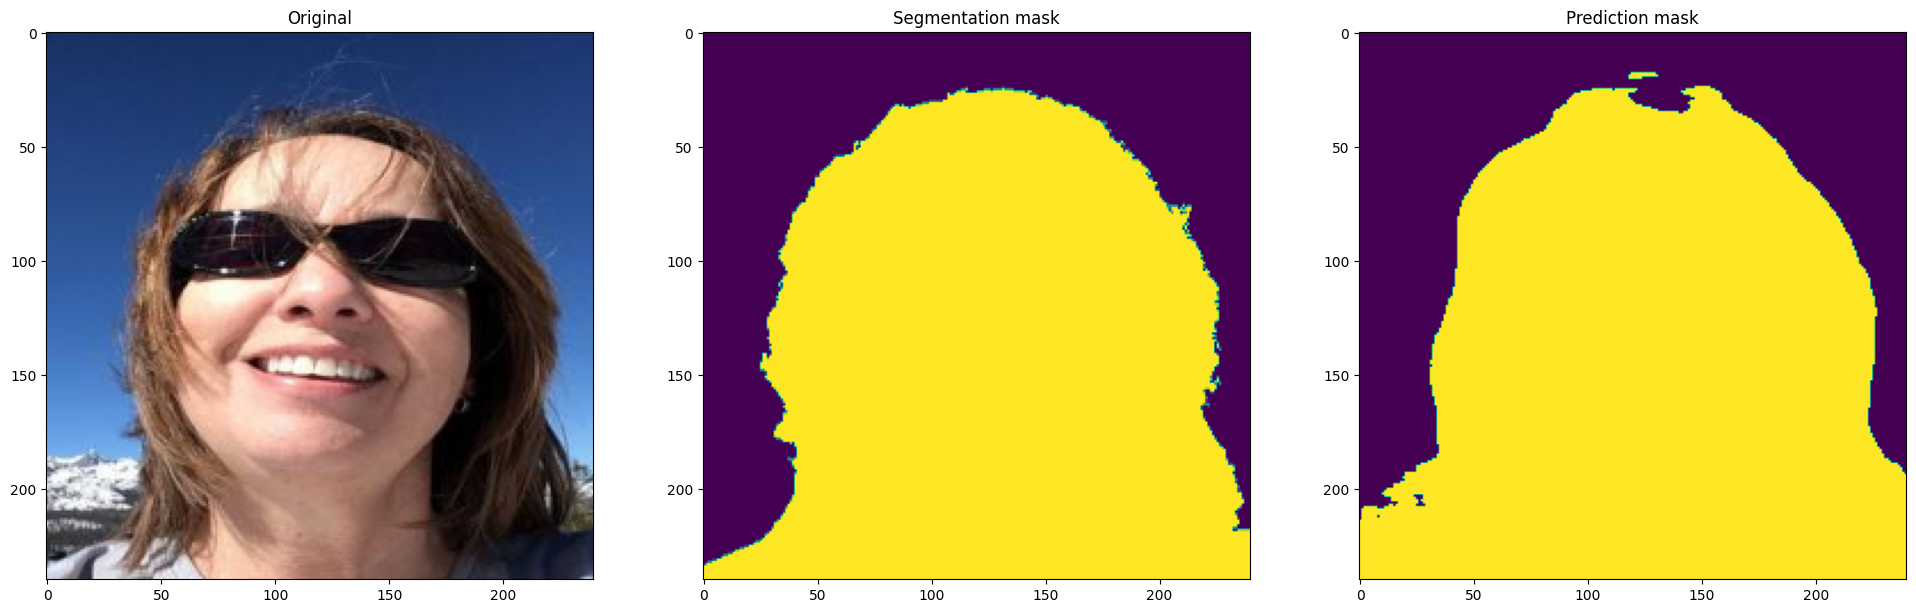

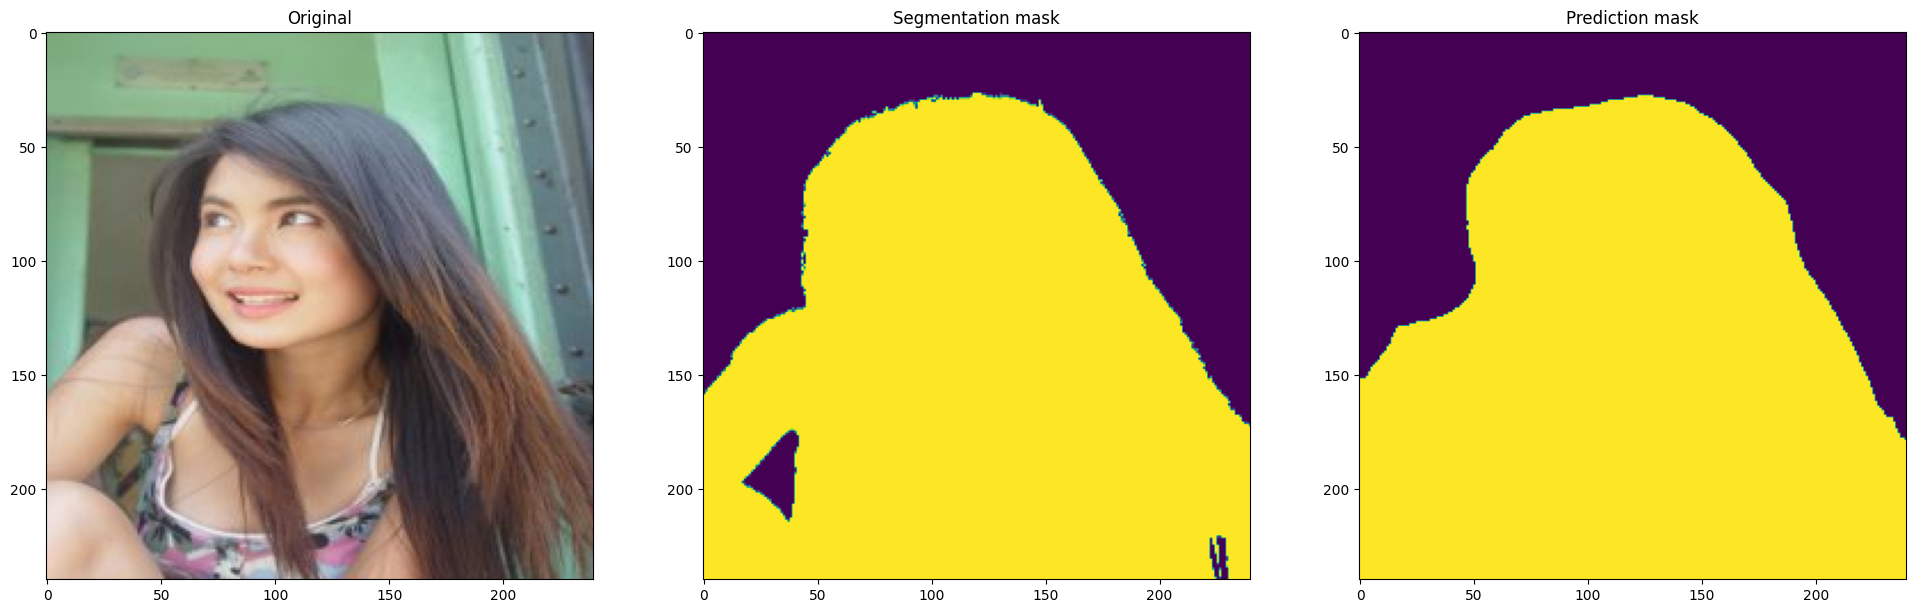

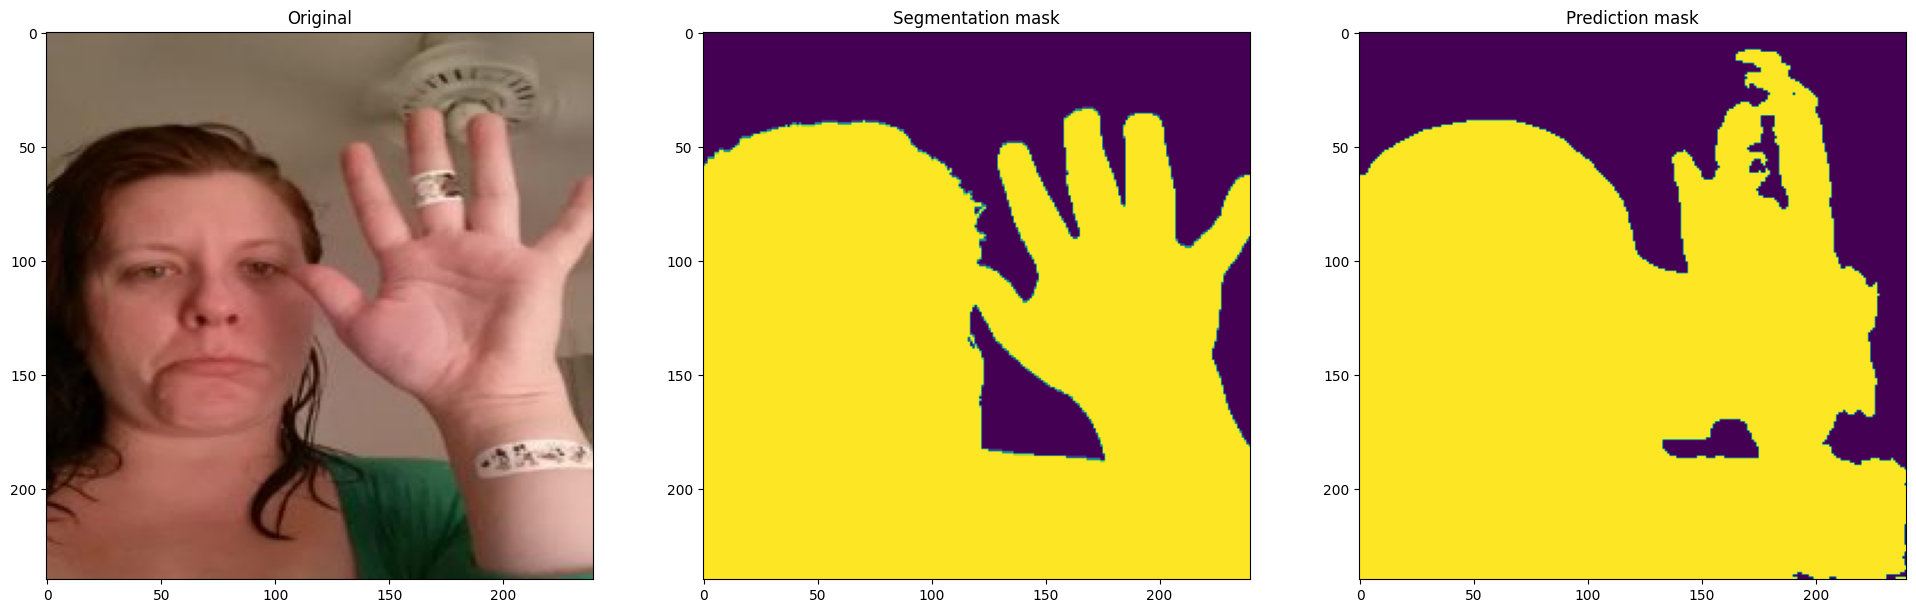

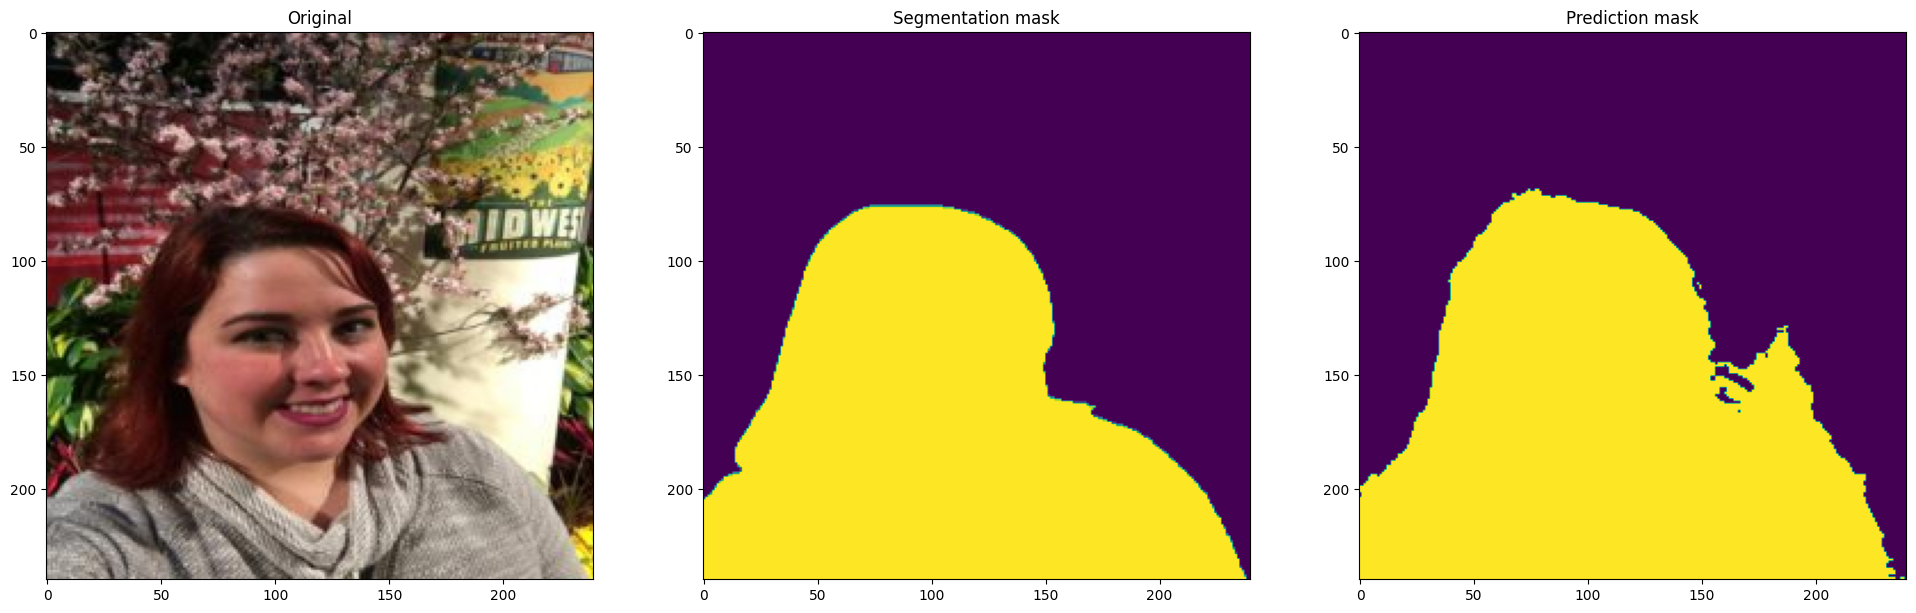

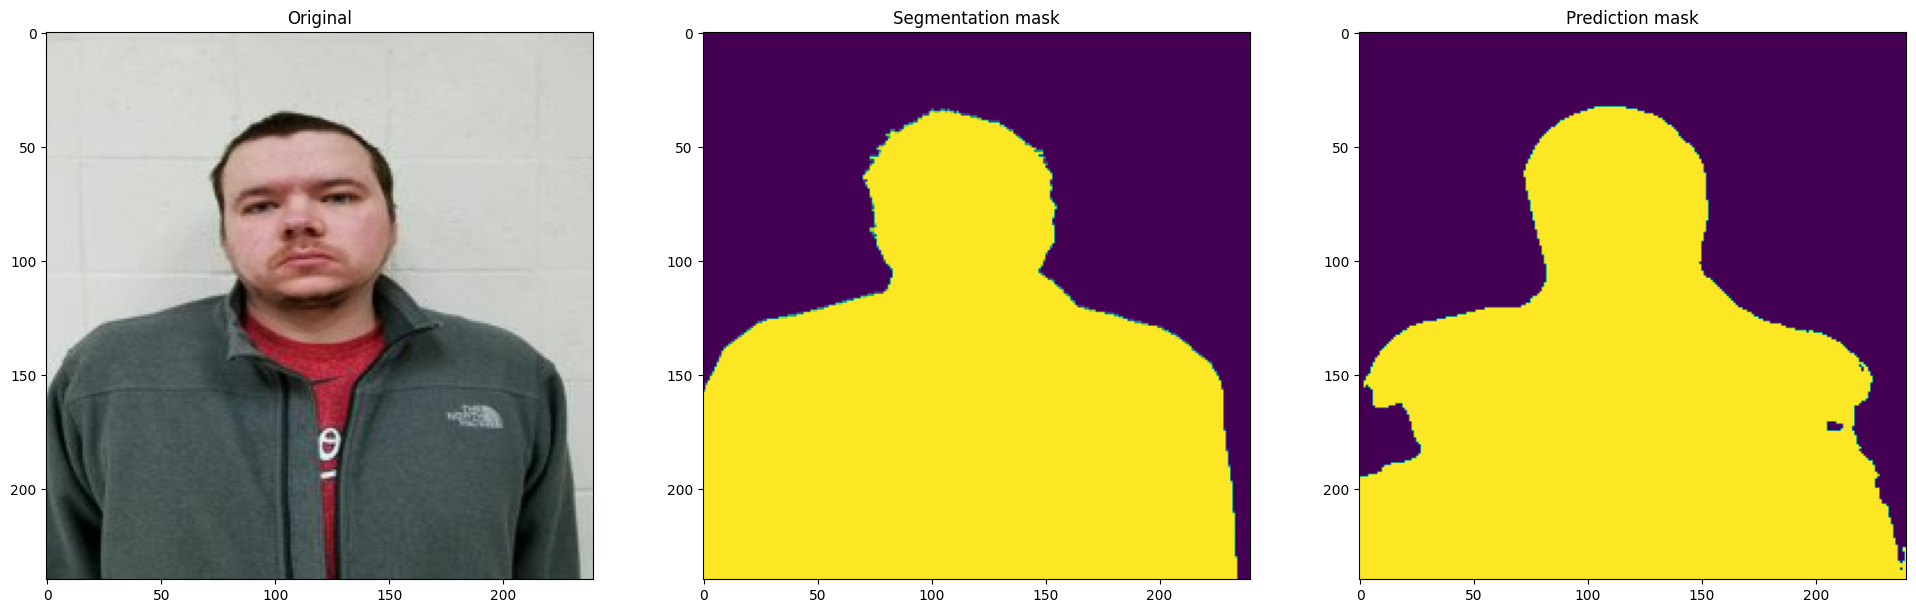

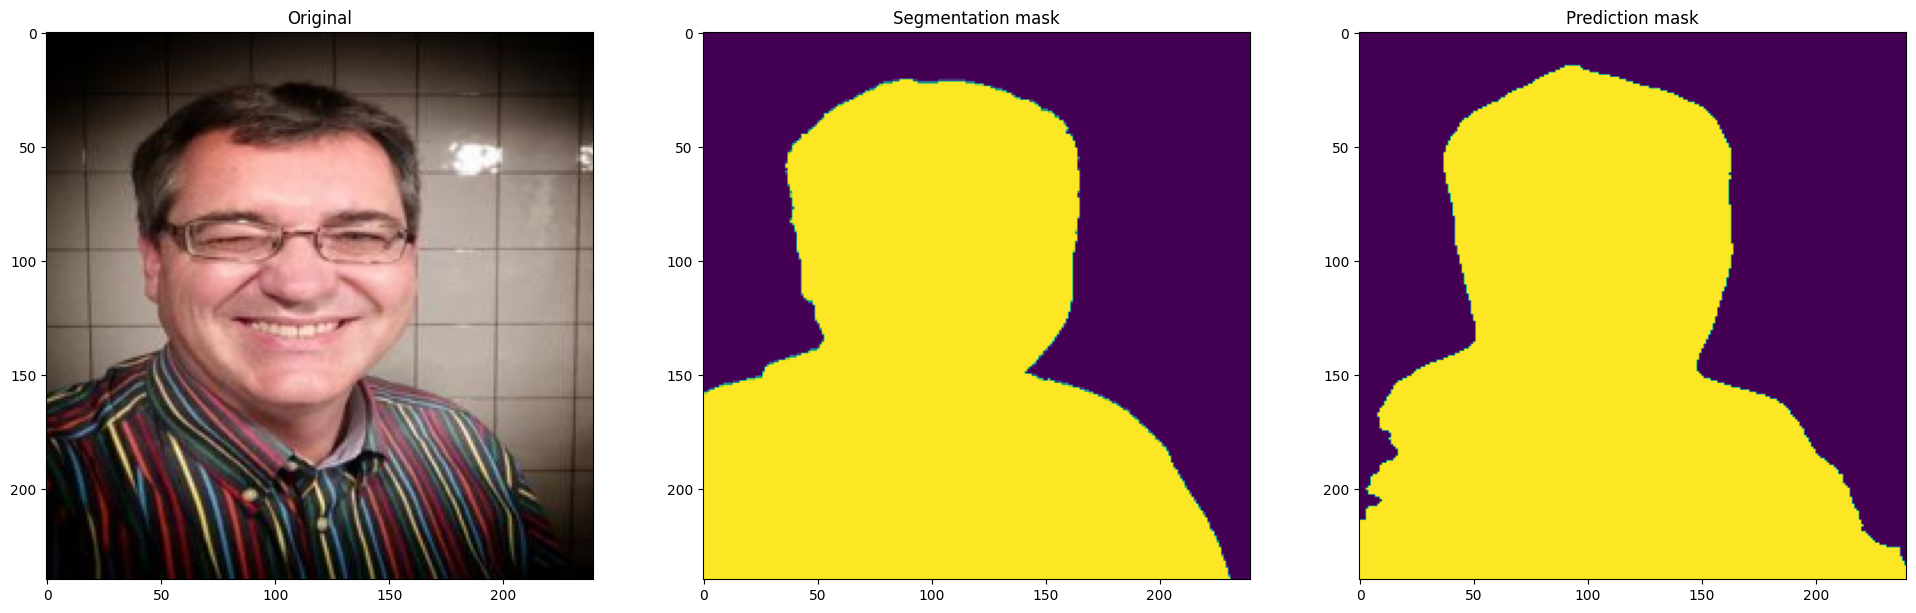

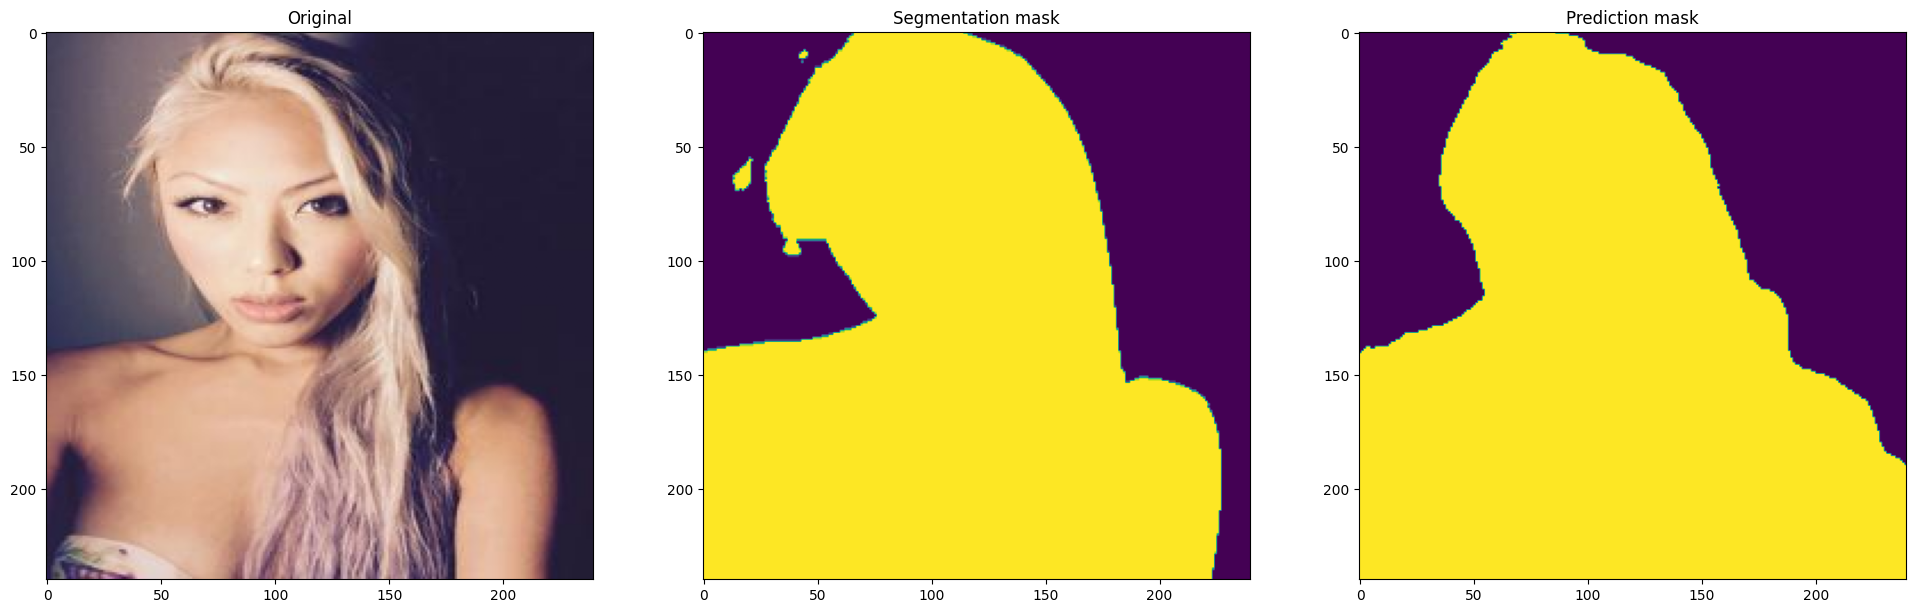

In [61]:
model.eval()

for imgs, masks in test_loader:
    preds = torch.sigmoid(model(imgs.to(device)))
    preds = preds > th

    for _, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
        fig, ax = plt.subplots(1, 3, figsize=(24, 8))

        ax[0].imshow(img.detach().cpu().numpy().transpose([1, 2, 0]))
        ax[1].imshow(mask.detach().cpu().numpy().transpose([1, 2, 0]))
        ax[2].imshow(pred.detach().cpu().numpy().transpose([1, 2, 0]))

        ax[0].set_title('Original')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction mask')

        plt.show()

    break


## **4. Сделай лучше**

### **Задание 5**. (2 балла)

Мы уже молодцы, но можно лучше. Осталась последняя часть - получить на тесте реально хорошие метрики.

**(1 балл)** Получи avg test dice score = 0.93.

**(1 балл)** Получи avg test dice score = 0.96.

**Во что потыкать при обучении:**
- Количество блоков
- Использовать **Dice Loss** для обучения
- Аугментации, препроцессинг
- Модифицировать исходные маски (например, убрать артефакты на границе с помощью фильтра)
- Постпроцессинг (порог для маски, постобработка маски - например, заполнить дыры)
- Во всё, что мы обсуждали по трюкам на занятии 2

In [62]:
# вот эту версию можно использовать в качестве loss-а
def dice_loss(pred_tensor, target_tensor):
    smooth = 1.

    iflat = pred_tensor.contiguous().view(-1)
    tflat = target_tensor.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat)
    B_sum = torch.sum(tflat)

    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

Я провел разные эксперименты и получил следующие результаты:
1. Использовать dice_loss мне не помогло, больше 0.85 модель не смогла обучится поэтому я оставил BCEWithLogitsLoss
2. Пробовал разные аугментации, например такие как ColorJitter, RandomHorizontalFlip, RandomVerticalFlip тоже не помогло только ухудшало модель больше 0.94 не смог обучится
3. Но что мне действительно помогло так это увеличить число блоков (5), количество фильтров 64, уменьшить weight_decay 1e-4, задать batch_size 16, увеличить число эпох (запускал и на 100 и на 200, получил результат что и 60 эпох достаточно)

Результат одного из экспериментов

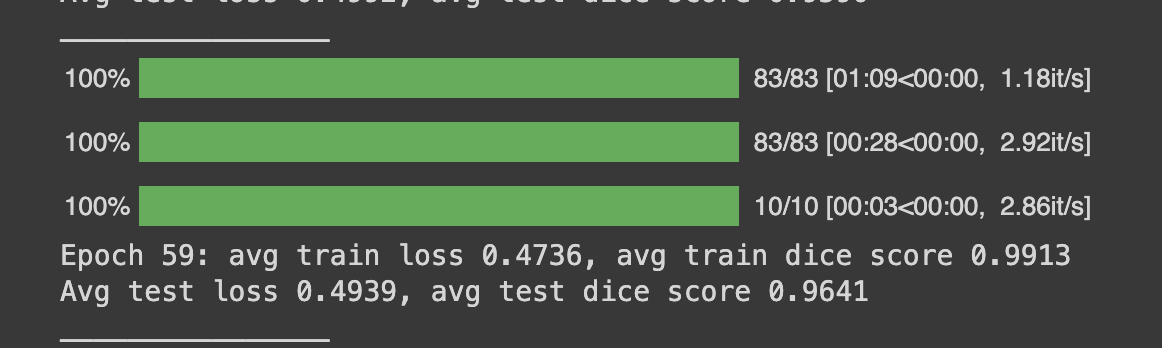

Итоговый эксперимент:

In [63]:
transform_v2 = v2.Compose([v2.Resize(size=(240, 240))])

train_dataset_v2 = FaceDataset(train_dir, transform=transform_v2)
test_dataset_v2 = FaceDataset(test_dir, transform=transform_v2)

batch_size_v2 = 16

train_loader_v2 = DataLoader(train_dataset_v2,
                          batch_size=batch_size_v2,
                          shuffle=True,
                          pin_memory=True)

test_loader_v2 = DataLoader(test_dataset_v2,
                         batch_size=batch_size_v2,
                         shuffle=False,
                         pin_memory=True)

In [64]:
model_v2 = UNet(num_classes=1, num_filters=64, num_blocks=5, batch_norm=True).to(device)
optimizer_v2 = optim.AdamW(model_v2.parameters(), lr=3e-4, weight_decay=1e-4)
criterion_v2 = nn.BCEWithLogitsLoss()

In [ ]:
epochs = 60
for epoch in range(1, epochs):
    train_epoch(model_v2, optimizer_v2, train_loader_v2, criterion_v2, device)
    train_loss, train_dice = evaluate_loss(train_loader_v2, model_v2, criterion_v2, th, device)
    test_loss, test_dice = evaluate_loss(test_loader_v2, model_v2, criterion_v2, th, device)

    print(f'Epoch {epoch}: avg train loss {train_loss:.04f}, avg train dice score {train_dice:.04f}')
    print(f'Avg test loss {test_loss:.04f}, avg test dice score {test_dice:.04f}')
    print('________________')

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: avg train loss 0.6161, avg train dice score 0.8147
Avg test loss 0.6180, avg test dice score 0.8153
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 2: avg train loss 0.6096, avg train dice score 0.8154
Avg test loss 0.6098, avg test dice score 0.8229
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 3: avg train loss 0.5846, avg train dice score 0.8603
Avg test loss 0.5918, avg test dice score 0.8535
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 4: avg train loss 0.5773, avg train dice score 0.8692
Avg test loss 0.5822, avg test dice score 0.8669
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 5: avg train loss 0.5501, avg train dice score 0.8680
Avg test loss 0.5568, avg test dice score 0.8592
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 6: avg train loss 0.5490, avg train dice score 0.8967
Avg test loss 0.5546, avg test dice score 0.8943
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 7: avg train loss 0.5362, avg train dice score 0.9129
Avg test loss 0.5403, avg test dice score 0.9108
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 8: avg train loss 0.5394, avg train dice score 0.9177
Avg test loss 0.5438, avg test dice score 0.9119
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 9: avg train loss 0.5247, avg train dice score 0.9270
Avg test loss 0.5283, avg test dice score 0.9260
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 10: avg train loss 0.5181, avg train dice score 0.9174
Avg test loss 0.5242, avg test dice score 0.9081
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 11: avg train loss 0.5290, avg train dice score 0.9394
Avg test loss 0.5330, avg test dice score 0.9354
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 12: avg train loss 0.5094, avg train dice score 0.9364
Avg test loss 0.5142, avg test dice score 0.9333
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 13: avg train loss 0.5173, avg train dice score 0.9395
Avg test loss 0.5231, avg test dice score 0.9338
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 14: avg train loss 0.5338, avg train dice score 0.9325
Avg test loss 0.5428, avg test dice score 0.9221
________________


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 15: avg train loss 0.5241, avg train dice score 0.9469
Avg test loss 0.5309, avg test dice score 0.9383
________________


  0%|          | 0/83 [00:00<?, ?it/s]

### **GL, HF!**